# Bitcoin Price Prediction using RNN (Recurring Neural Network)
##DTSA 5011 Introduction to Deep Learning - Final Project

###**Overview**

According to Investopedia, a cryptocurrency is a digital or virtual currency that is secured by cryptography, which makes it nearly impossible to counterfeit or double-spend. They are decentralized networks based on blockchain technology. Bitcoin is the number 1 cryptocurrency today with a Market capitalization of ~450 Billion Dollars as of 8/12/2022. It has been one of the popular topics today as many are still wary about its nature. But also, investors significantly grew and attracted institutions including big names in the investment industry. 

The data is collected from  <a href="https://finance.yahoo.com/quote/BTC-USD/history?period1=1410825600&period2=1660694400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true">finance.yahoo.com</a> which contains all historical prices of Bitcoin per day. In this particular analysis, we will use the close price as the main variable.

The goal of this project is to build a predictive model using RNN (Recurring Neural Network). According to <a href="https://www.ibm.com/cloud/learn/recurrent-neural-networks">ibm.com</a>, a recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. This model is suitable for our data since it is a time series data consisting of 2,891 rows of data. Let us explore more of our dataset below!

###**Exploratory Data Analysis (EDA)**

In [1]:
import numpy as np
import pandas as pd
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,9/17/2014,465.86,468.17,452.42,457.33,457.33,21056800.0
1,9/18/2014,456.86,456.86,413.10,424.44,424.44,34483200.0
2,9/19/2014,424.10,427.83,384.53,394.80,394.80,37919700.0
3,9/20/2014,394.67,423.30,389.88,408.90,408.90,36863600.0
4,9/21/2014,408.08,412.43,393.18,398.82,398.82,26580100.0


In [3]:
df.shape

(2891, 7)

In [4]:
# check for nulls
df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2891 non-null   object 
 1   Open         2891 non-null   float64
 2   High         2891 non-null   float64
 3   Low          2891 non-null   float64
 4   Close*       2891 non-null   float64
 5   Adj Close**  2891 non-null   float64
 6   Volume       2891 non-null   float64
dtypes: float64(6), object(1)
memory usage: 158.2+ KB


In [6]:
# format Date column to date
df['Date'] = df['Date'].astype('datetime64[ns]')

Good thing we do not have null values and we've performed data formatting. Now that we've cleaned our data, let's look at the historical data in a plot.

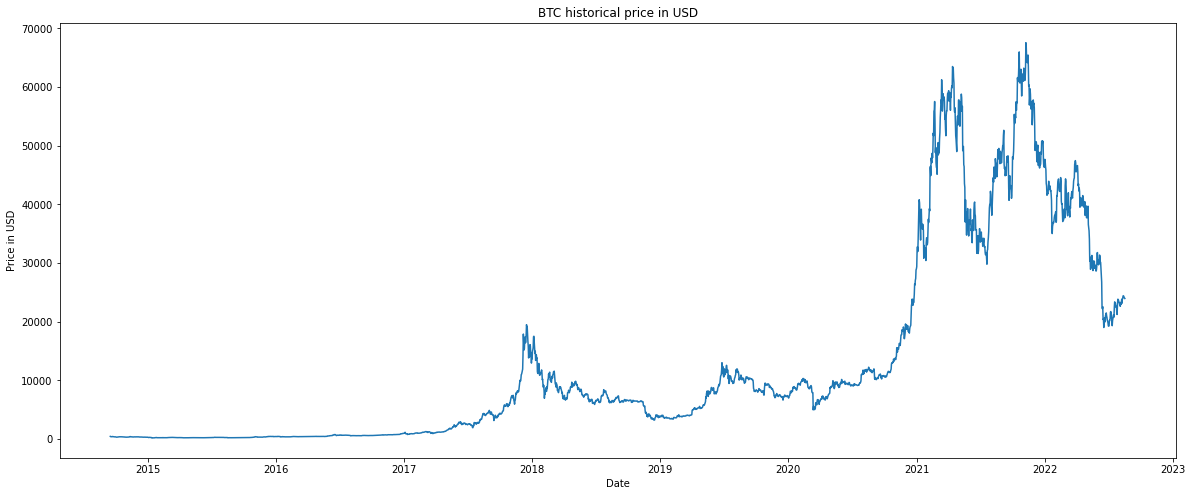

In [25]:
plt.figure(figsize=(20,8))
plt.title('BTC historical price in USD')
plt.plot(df['Date'], df['Close*'])
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

###**Model Architecture**

Before we go to training the model, let us identify the train and test dataset. First we need to scale the data using MinMaxScaler to avoid issues during the training. Once the data is scaled, we assign the train and datasets. The step variable is the number of days we want the model to influence previous value which we set to 90 days. The model consists of 2 LSTM layer and 2 Dense layer consisting of 1 final dense layer.



In [8]:
data = df.filter(['Close*'])
ds = data.values

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(ds)
df1

array([[0.00414357],
       [0.00365551],
       [0.00321567],
       ...,
       [0.35823839],
       [0.3555323 ],
       [0.35297371]])

In [11]:
train_size = round(len(df1) * 0.90)
test_size = len(df1) - train_size

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1), :1]

In [12]:
train_size, test_size

(2602, 289)

In [13]:
time_step = 60
X_train = []
y_train = []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])
    if i<= time_step + 1:
        print(X_train)
        print(y_train)
        print()

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

[array([0.00414357, 0.00365551, 0.00321567, 0.00342491, 0.00327533,
       0.00332474, 0.00382393, 0.00363711, 0.00346453, 0.00335843,
       0.00328571, 0.0029542 , 0.00292883, 0.00309903, 0.00304962,
       0.00292289, 0.00269199, 0.00223732, 0.00211326, 0.00225527,
       0.00234594, 0.0025945 , 0.00277391, 0.00272241, 0.00273339,
       0.00297453, 0.00315053, 0.00330575, 0.00321523, 0.00303404,
       0.00305185, 0.00316581, 0.00313777, 0.00303834, 0.00309221,
       0.00304294, 0.00267582, 0.00267478, 0.00251036, 0.00262062,
       0.00259524, 0.00266395, 0.00233704, 0.00248113, 0.00237755,
       0.00219102, 0.0021931 , 0.00221773, 0.00226136, 0.00239491,
       0.00254034, 0.00243839, 0.00248395, 0.00274764, 0.00280195,
       0.00281353, 0.00364245, 0.00360045, 0.00326049, 0.00293862])]
[0.003112983432096138]

[array([0.00414357, 0.00365551, 0.00321567, 0.00342491, 0.00327533,
       0.00332474, 0.00382393, 0.00363711, 0.00346453, 0.00335843,
       0.00328571, 0.0029542 , 0.0

(2542, 60, 1)

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, batch_size = 32, epochs = 3)

Epoch 1/3
80/80 [==============================] - 1s 14ms/step - loss: 1.7286e-04
Epoch 2/3
80/80 [==============================] - 1s 10ms/step - loss: 1.2863e-04
Epoch 3/3
80/80 [==============================] - 1s 9ms/step - loss: 1.2853e-04


In [37]:
# Create the data for X_test and y_test

test_data = df1[train_size - 60: , :]

X_test = []
y_test = ds[train_size:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))


In [39]:
# Preict the values
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

# Root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((pred - y_test) ** 2)))
rmse


1403.071027526777

We have succesfuly built a predictive model using RNN with LSTM layers. Let see the predictions, train and validation sets in the plot.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


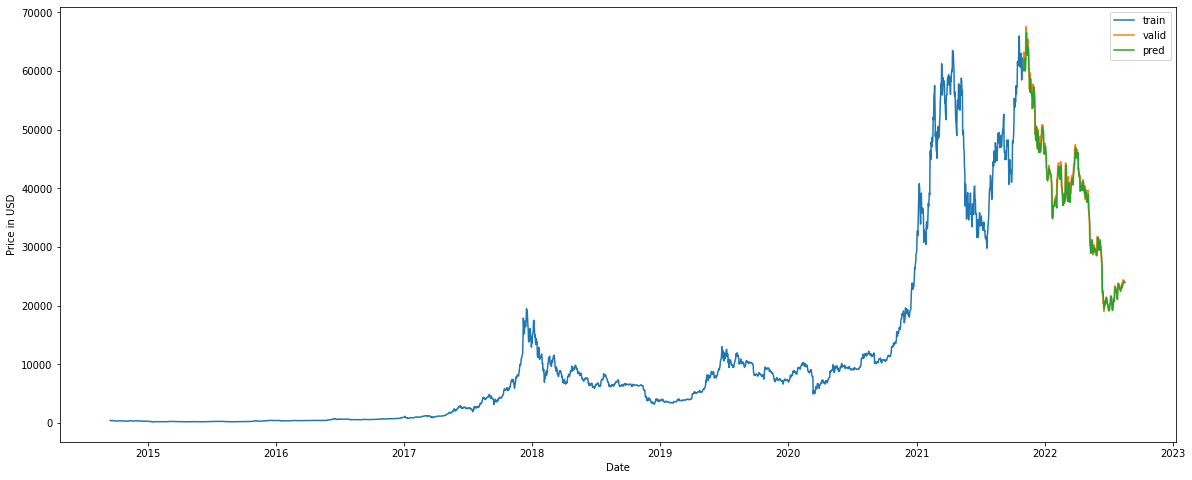

In [36]:
# Plot the data with predictions
train = df[:train_size]
valid = df[train_size:]
valid['pred'] = pred
plt.figure(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(train['Date'],train['Close*'])
plt.plot(valid['Date'],valid[['Close*', 'pred']])
plt.legend(['train', 'valid', 'pred'], loc='upper right')
plt.show()